## Lesson 12 Homework
* Implement the k means clustering algorithm
* Get it working on GPU

In [59]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

n_clusters=6
n_samples = 250

centroids = torch.rand(n_clusters, 2)*70-35

from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

def sample(m): return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,))


slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

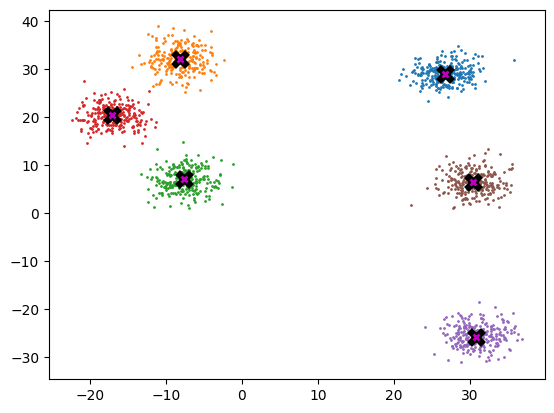

In [60]:
plot_data(centroids, data, n_samples)

### K Means Clustering
* For each data point we randomly assing it to one of the K clusters
* Then we compute the centroid of each cluster and reassign each datapoint to the cluster with the closest centroid

Algorithm
1. Choose a number of clusters
2. Initialize the centroids
3. Assign each data point to the nearest centroid
4. Update the centroids based on the assignments

In [61]:
data.shape

torch.Size([1500, 2])

#### 1. Choose number of clusters

In [62]:
k = 6

#### 2. Initialize Centroids

In [63]:
data.shape[0]

1500

In [64]:
# Returns random permutation of integers from 0 to n -1
torch.randperm(data.shape[0])

tensor([ 644,  150,   64,  ...,  942,  103, 1119])

In [65]:
# Take the first K to initialize our centroids
indices = torch.randperm(data.shape[0])[:k]
centroids = data[indices]
centroids

tensor([[ 23.659,  26.174],
        [ 28.448,   4.971],
        [ -9.358,  34.029],
        [ 33.595,   5.530],
        [ 31.943,   6.260],
        [ 31.221, -26.978]])

In [66]:
def initialize_centroids(data, k):
    indices = torch.randperm(data.shape[0])[:k]
    centroids = data[indices]
    return centroids

#### 3. Assign each data point to the nearest centroid

In [67]:
# Computes batched the p-norm distance between each pair of the two collections of row vectors.
torch.cdist(data, centroids)

tensor([[ 2.551, 21.495, 36.382, 22.092, 20.892, 53.563],
        [ 4.521, 25.392, 35.256, 25.918, 24.756, 57.458],
        [ 7.226, 23.805, 40.146, 23.379, 22.484, 55.677],
        ...,
        [18.291,  4.934, 47.125,  4.729,  3.279, 36.305],
        [22.933,  1.359, 49.018,  4.522,  3.463, 30.994],
        [22.175,  2.741, 49.671,  2.437,  1.227, 32.287]])

In [68]:
distances = torch.cdist(data, centroids)

* Distances is the distance between each point and each of the centroids
* We can find which centroid each point is closest to by finding the min of each row of distances with argmin

In [69]:
# Returns the indices of the minimum value(s) of the flattened tensor or along a dimension
torch.argmin(distances, dim=1)

tensor([0, 0, 0,  ..., 4, 1, 4])

In [70]:
def assign_clusters(data, centroids):
    distances = torch.cdist(data, centroids)
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

#### 4. Update centroids based on the assignemnts

In [71]:
centroids = initialize_centroids(data, k)
centroids

tensor([[ -7.927,  33.220],
        [ 34.584, -24.170],
        [ 29.631,   6.903],
        [ 31.771, -25.679],
        [ 24.611,  30.909],
        [ 29.018,   6.224]])

In [72]:
cluster_assignments = assign_clusters(data, centroids)
cluster_assignments

tensor([4, 4, 4,  ..., 2, 5, 2])

In [73]:
new_centroids = torch.zeros((k, data.shape[1]))
new_centroids

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [74]:
cluster_assignments == 4

tensor([ True,  True,  True,  ..., False, False, False])

In [75]:
data[cluster_assignments == 4]

tensor([[26.204, 26.349],
        [25.691, 30.213],
        [30.431, 28.693],
        [25.647, 30.033],
        [31.236, 30.093],
        [30.276, 26.987],
        [29.619, 31.949],
        [28.124, 32.035],
        [24.275, 29.255],
        [21.578, 28.565],
        [23.663, 27.102],
        [26.259, 32.890],
        [25.435, 28.909],
        [24.906, 29.790],
        [23.276, 31.277],
        [24.792, 27.706],
        [29.693, 30.587],
        [24.323, 28.256],
        [24.715, 27.579],
        [26.933, 30.226],
        [29.395, 28.079],
        [23.659, 26.174],
        [23.621, 29.131],
        [26.617, 30.561],
        [27.580, 29.443],
        [29.856, 28.053],
        [29.990, 30.965],
        [31.719, 30.220],
        [29.387, 30.305],
        [25.746, 27.325],
        [26.374, 30.222],
        [26.885, 30.004],
        [27.200, 26.492],
        [27.515, 32.850],
        [26.783, 28.293],
        [23.761, 27.741],
        [25.497, 31.412],
        [23.474, 32.255],
        [28.

In [76]:
data[cluster_assignments == 4].mean(dim=0)

tensor([26.780, 29.194])

In [77]:
def update_centroids(data, cluster_assignments, k):
    new_centroids = torch.zeros((k, data.size(1)))
    for i in range(k):
        cluster_points = data[cluster_assignments == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(dim=0)
    return new_centroids

In [78]:
update_centroids(data, cluster_assignments, k)

tensor([[-10.937,  19.788],
        [ 34.167, -23.913],
        [ 31.383,   7.491],
        [ 30.208, -25.777],
        [ 26.780,  29.194],
        [ 28.840,   4.855]])

In [79]:
def kmeans(data, k, num_iterations=100):
    centroids = initialize_centroids(data, k)
    for _ in range(num_iterations):
        cluster_assignments = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, cluster_assignments, k)
        if torch.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_assignments

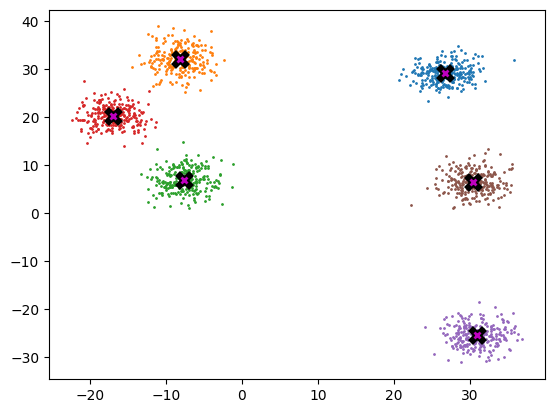

In [80]:
centroids, cluster_assignments = kmeans(data, k)
plot_data(centroids, data, n_samples)

In [81]:
%time centroids, cluster_assignments = kmeans(data, k)

CPU times: user 6.45 ms, sys: 2.16 ms, total: 8.61 ms
Wall time: 5.71 ms


### CUDA
Now lets try doing it batched on the GPU

In [122]:
k = 6

def initialize_centroids(data, k):
    indices = torch.randperm(data.shape[0])[:k]
    centroids = data[indices]
    return centroids

def assign_clusters(data, centroids):
    distances = torch.cdist(data, centroids)
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

def update_centroids(data, cluster_assignments, k, new_centroids):
    for i in range(k):
        cluster_points = data[cluster_assignments == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(dim=0)
    return new_centroids

def kmeans(data, k, num_iterations=100):
    centroids = initialize_centroids(data, k)
    new_centroids = torch.zeros((k, data.size(1))).cuda()
    for _ in range(num_iterations):
        cluster_assignments = assign_clusters(data, centroids)
        update_centroids(data, cluster_assignments, k, new_centroids)
        if torch.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_assignments

In [123]:
data = data.cuda()
centroids, cluster_assignments = kmeans(data, k)

In [124]:
%timeit -n 10 centroids, cluster_assignments = kmeans(data, k)

4.72 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


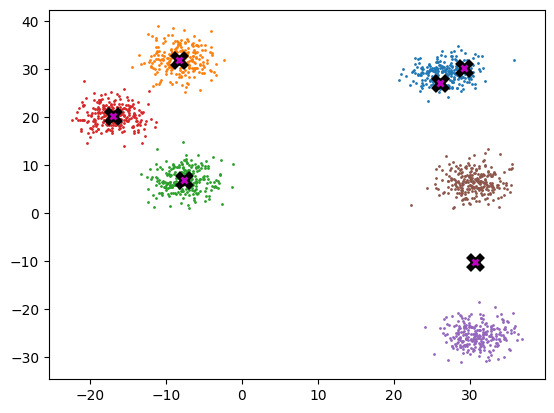

In [125]:
plot_data(centroids.cpu(), data.cpu(), n_samples)

The algorithm works and it is running on GPU but it isn't any faster than on the cpu since we are processing the data in batches

I'm struggling to figure out how to run this algorithm in batches and after looking online, it has been done but it looks difficult.

Maybe I'll return to this at a later data